In [1]:
%tensorflow_version 2.x

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.2.0


In [ ]:
# Read the data file
df = pd.read_csv("./SAS1.csv")
df.head(5)

ds    y
0  6/18/2018   10
1  6/19/2018  134
2  6/20/2018  125
3  6/21/2018  142
4  6/22/2018  125

In [ ]:
# Generate a Series
drinks_amount = df['y']
drinks_amount.index = df['ds']
drinks_amount.head()

ds
6/18/2018     10
6/19/2018    134
6/20/2018    125
6/21/2018    142
6/22/2018    125
Name: y, dtype: int64

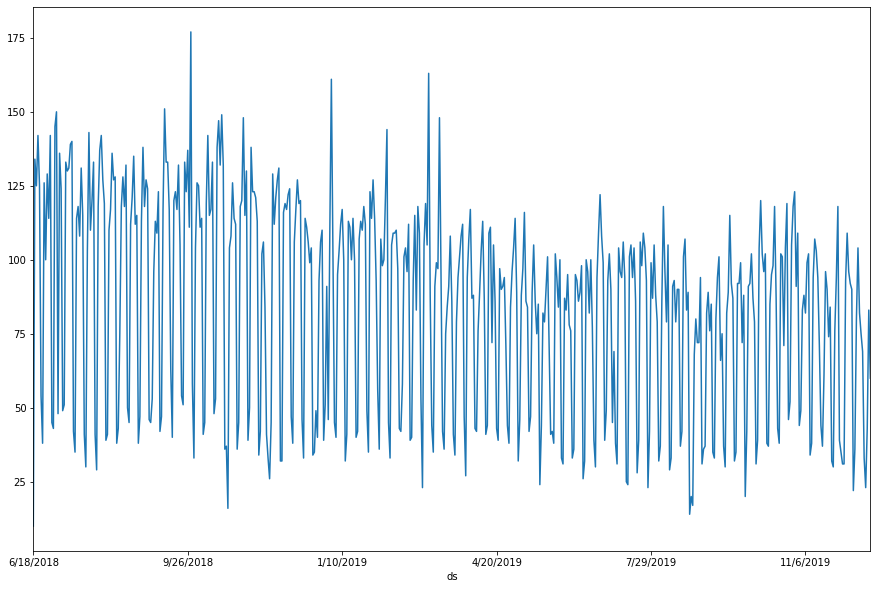

In [ ]:
# Plot the daily drink amount 
drinks_amount.plot(figsize=(15, 10))

In [ ]:
drinks_data = drinks_amount.values

In [ ]:
# Get the mean and std of the traning dataset
TRAIN_SPLIT = 400
train_mean = drinks_data[:TRAIN_SPLIT].mean()
train_std = drinks_data[:TRAIN_SPLIT].std()
print(train_mean, train_std)

88.065 36.30297198577549


In [ ]:
drinks_data = (drinks_data - train_mean) / train_std
drinks_data.shape

(543,)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
drinks_data = [[1, 2, 3, 4, 5]]
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(drinks_data)

print(scaled)

[[-1. -1. -1. -1. -1.]]


In [ ]:
def assembel_data(dataset, start_index, end_index, history_size, target_size, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i - history_size, i)    
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    if single_step:
        labels.append(dataset[i + target_size])
    else:
        #print("*"*10)
        labels.append(dataset[i: i + target_size])
        #print(labels)
  return np.array(data), np.array(labels)

In [ ]:
# Assembel the data based on the history size and predicting size
history_size = 60
future_target = 14

'''
x_train, y_train = assembel_data(drinks_data, 0, TRAIN_SPLIT, history_size, future_target, single_step=True)
x_val, y_val = assembel_data(drinks_data, TRAIN_SPLIT, None, history_size, future_target, single_step=True)
'''

x_train, y_train = assembel_data(drinks_data, 0, TRAIN_SPLIT, history_size, future_target)
x_val, y_val = assembel_data(drinks_data, TRAIN_SPLIT, None, history_size, future_target)


In [ ]:
print("the size of the training set is: {}".format(x_train.shape[0])) # original 400
print("the size of the validation set is: {}".format(x_val.shape[0])) # origin 143

the size of the training set is: 340
the size of the validation set is: 69


In [ ]:
print ('history data sample:\n{}'.format(x_val[1]))
print ('target label sample:\n{}'.format(y_val[1]))

history data sample:
[[-2.93364411e-02]
 [ 4.66490733e-01]
 [-1.79048702e-03]
 [-2.49704074e-01]
 [-1.54436392e+00]
 [-1.40663415e+00]
 [-5.68823952e-02]
 [ 8.24588136e-01]
 [ 2.18577146e-01]
 [-2.49704074e-01]
 [ 4.66490733e-01]
 [-1.62700178e+00]
 [-1.51681796e+00]
 [ 8.08473753e-02]
 [ 1.35939283e-01]
 [-2.49704074e-01]
 [ 5.33014212e-02]
 [ 5.33014212e-02]
 [-1.40663415e+00]
 [-1.26890438e+00]
 [ 3.56306916e-01]
 [ 5.21582641e-01]
 [-1.39520258e-01]
 [ 2.57554671e-02]
 [-2.04019109e+00]
 [-1.87491537e+00]
 [-1.95755323e+00]
 [-5.52709569e-01]
 [-2.22158120e-01]
 [-4.42525753e-01]
 [-4.42525753e-01]
 [ 1.63485238e-01]
 [-1.57190987e+00]
 [-1.43418010e+00]
 [-1.40663415e+00]
 [-1.67066212e-01]
 [ 2.57554671e-02]
 [-3.32341936e-01]
 [-8.44283493e-02]
 [-1.46172605e+00]
 [-1.51681796e+00]
 [-2.22158120e-01]
 [ 1.63485238e-01]
 [ 3.56306916e-01]
 [-6.07801477e-01]
 [-3.59887890e-01]
 [-1.40663415e+00]
 [-1.59945582e+00]
 [-1.67066212e-01]
 [ 2.57554671e-02]
 [ 7.41950274e-01]
 [ 1.08393

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
BATCH_SIZE = 100
BUFFER_SIZE = 1000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
#one step lstm model
'''
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer='adam', loss='mae')
'''
#multi step lstm model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(tf.keras.layers.Dense(14))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 32)            4352      
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 32)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 14)                462       
Total params: 13,134
Trainable params: 13,134
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#test, to guarantee the output shape is correct
for x, y in val_univariate.take(3):
  print (multi_step_model.predict(x).shape)

(69, 14)
(69, 14)
(69, 14)


In [ ]:
# Train the model
EVALUATION_INTERVAL = 200
EPOCHS = 50

multi_step_history = multi_step_model.fit(train_univariate, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_univariate,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/50
200/200 [==============================] - 15s 75ms/step - loss: 0.7486 - val_loss: 0.6473
Epoch 2/50
200/200 [==============================] - 13s 64ms/step - loss: 0.6229 - val_loss: 0.4926
Epoch 3/50
200/200 [==============================] - 13s 64ms/step - loss: 0.5167 - val_loss: 0.4148
Epoch 4/50
200/200 [==============================] - 13s 63ms/step - loss: 0.4464 - val_loss: 0.3370
Epoch 5/50
200/200 [==============================] - 13s 63ms/step - loss: 0.4072 - val_loss: 0.3321
Epoch 6/50
200/200 [==============================] - 12s 62ms/step - loss: 0.3872 - val_loss: 0.3246
Epoch 7/50
200/200 [==============================] - 12s 62ms/step - loss: 0.3717 - val_loss: 0.3220
Epoch 8/50
200/200 [==============================] - 13s 63ms/step - loss: 0.3589 - val_loss: 0.3202
Epoch 9/50
200/200 [==============================] - 12s 62ms/step - loss: 0.3498 - val_loss: 0.3185
Epoch 10/50
200/200 [==================

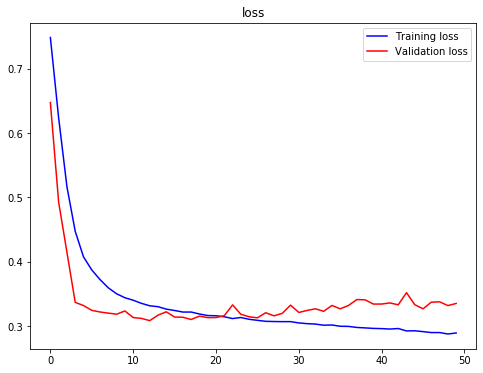

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.show()
  #plt.savefig('temp.png', dpi=fig.dpi)

plot_train_history(multi_step_history, "loss")

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history), 'go--', linewidth=2, markersize=5, label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo--',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'r*--',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

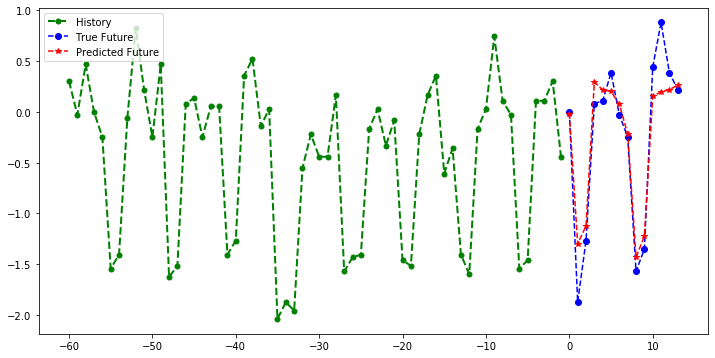

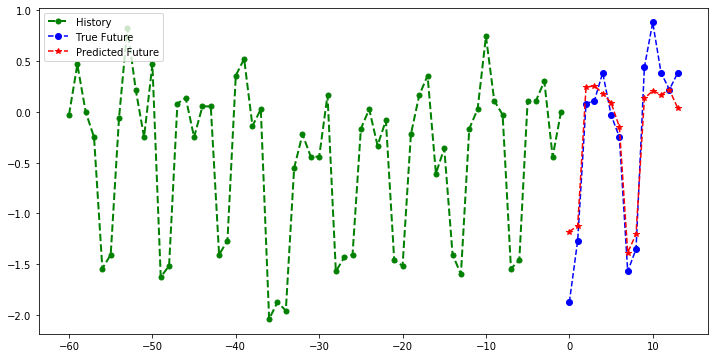

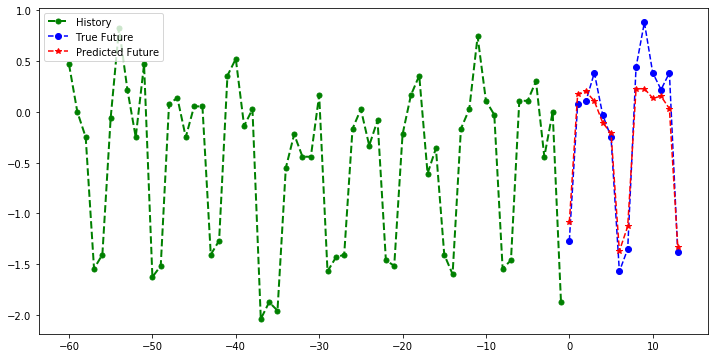

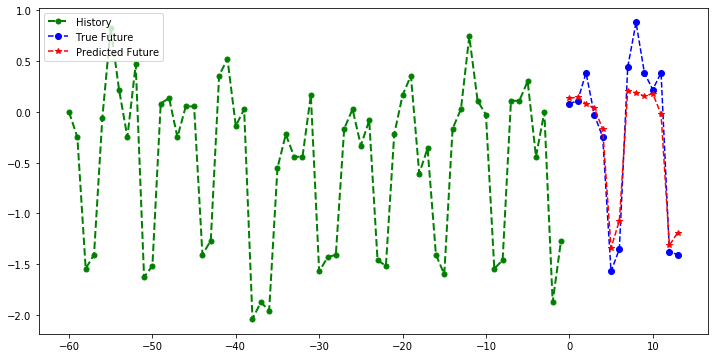

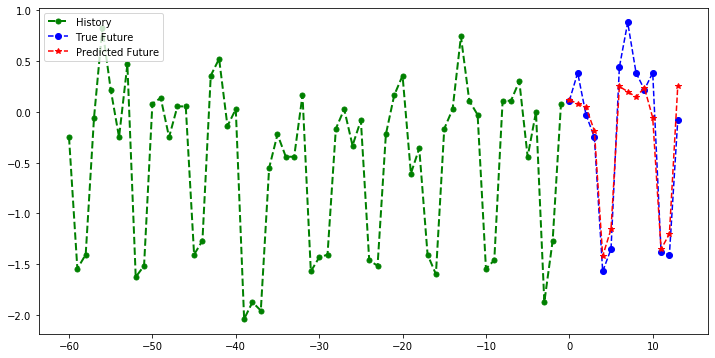

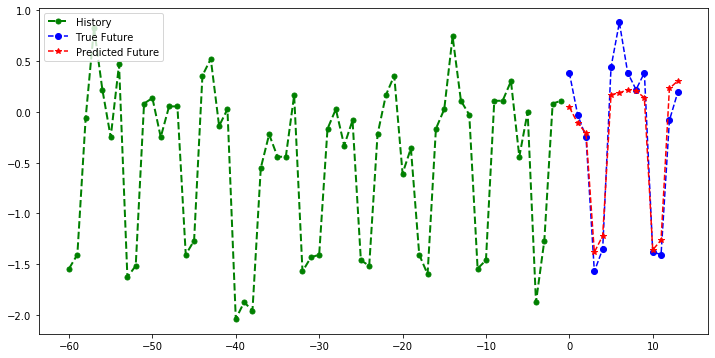

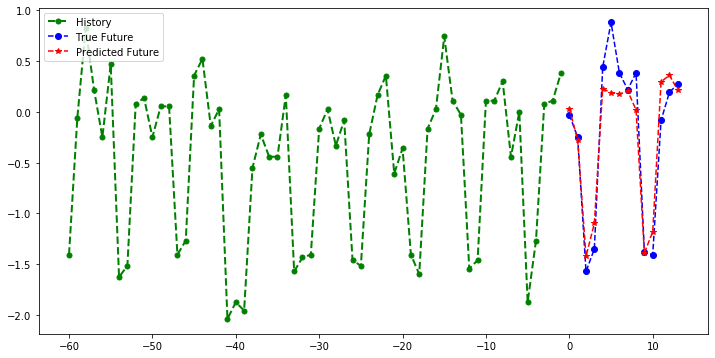

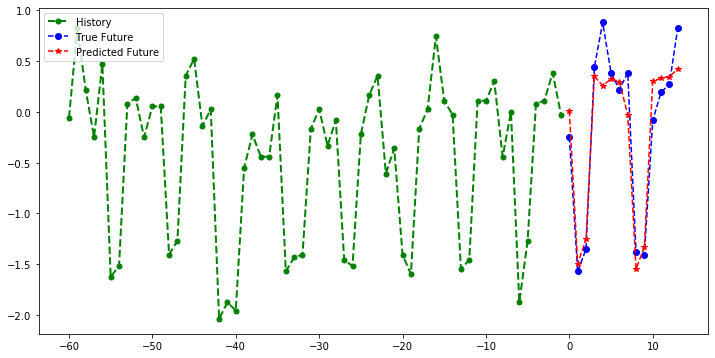

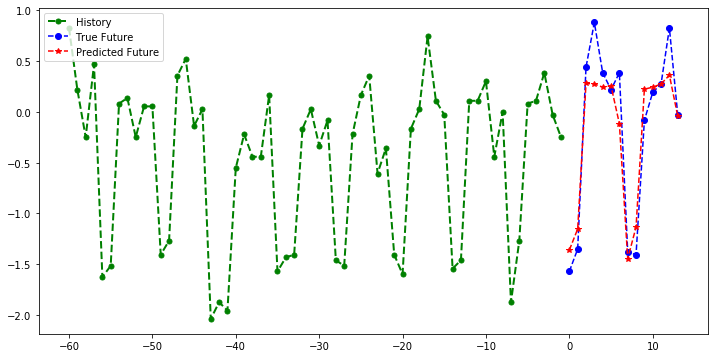

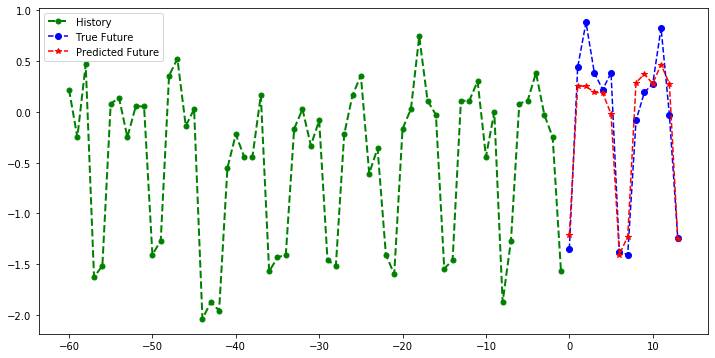

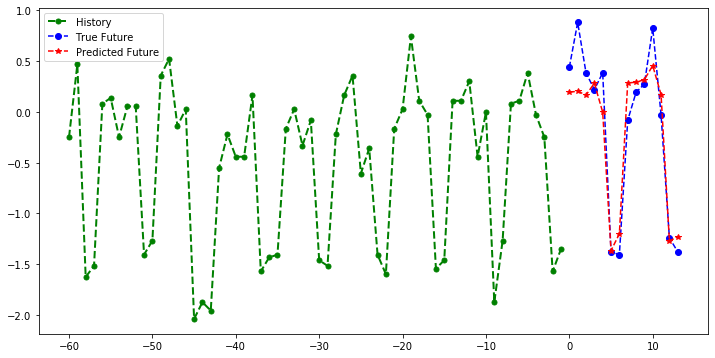

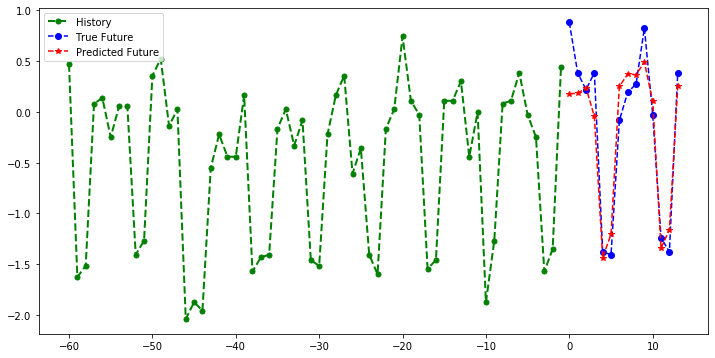

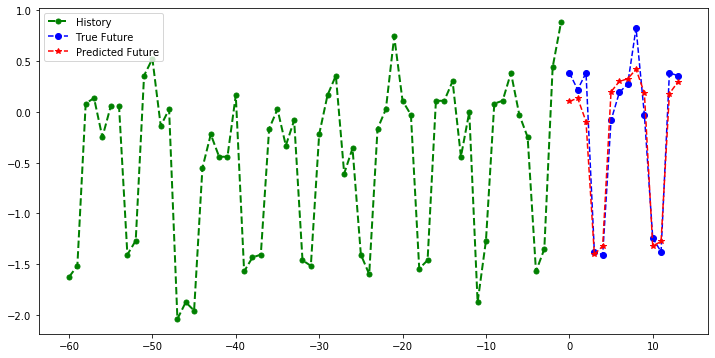

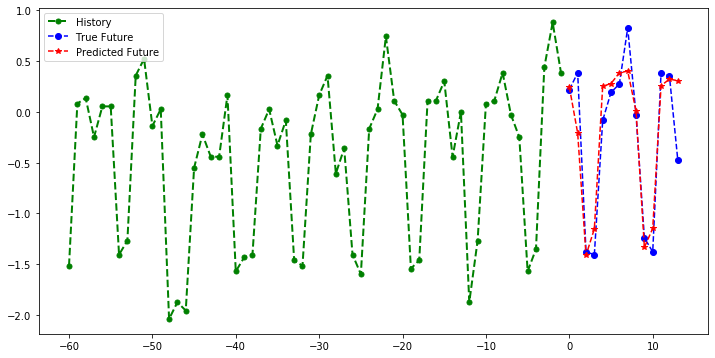

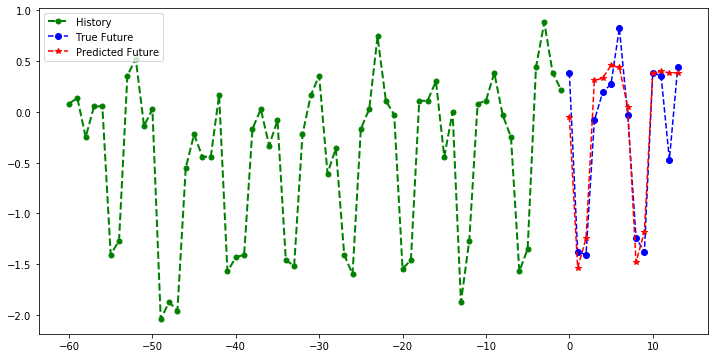

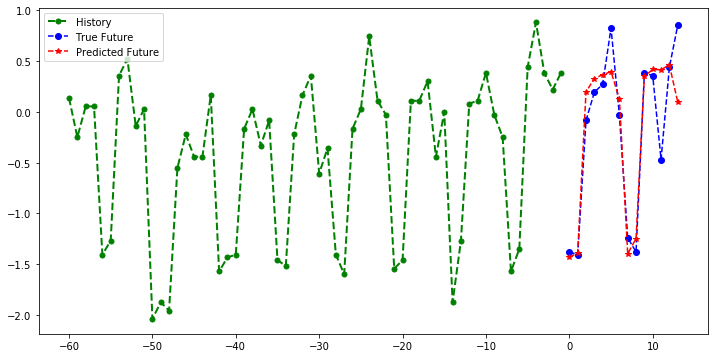

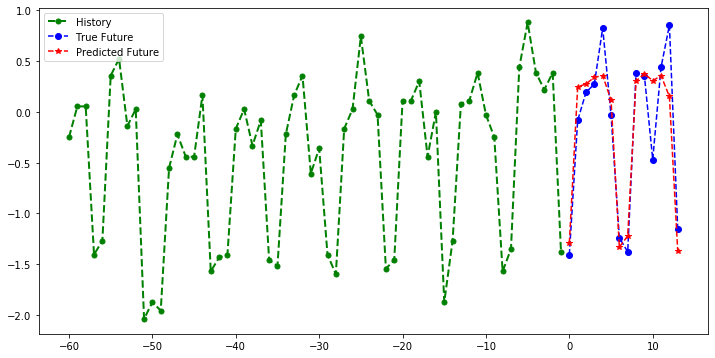

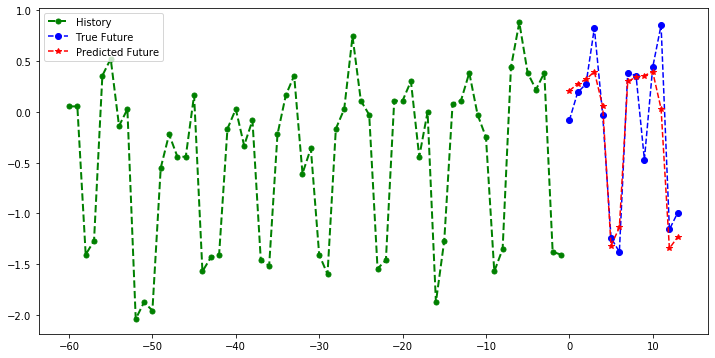

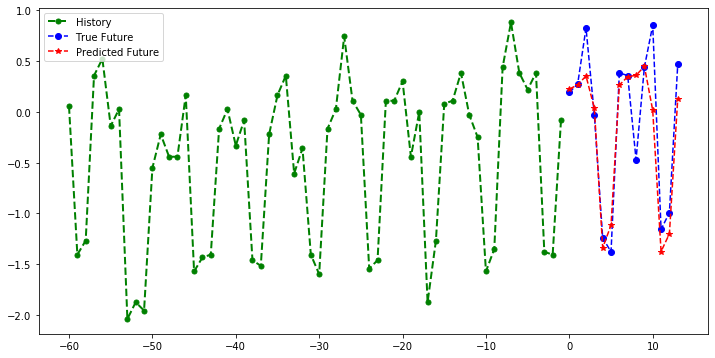

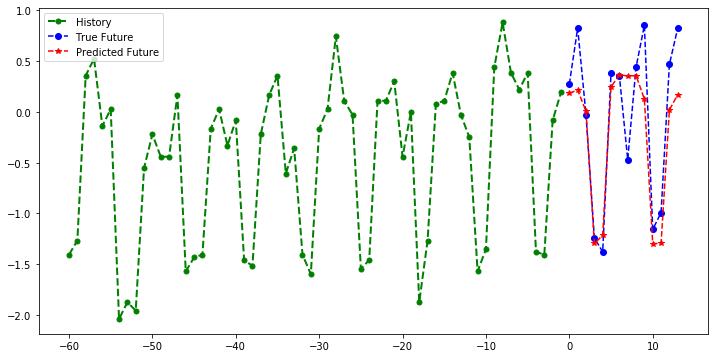

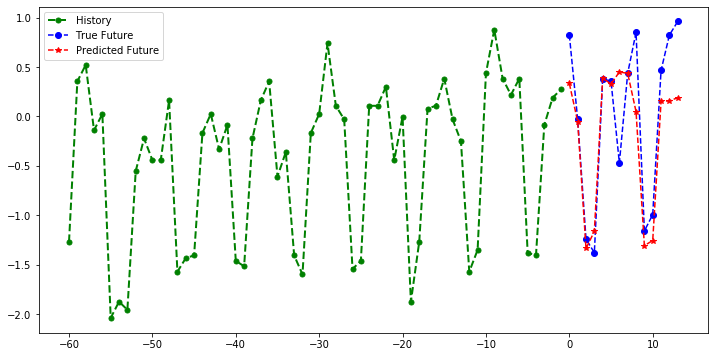

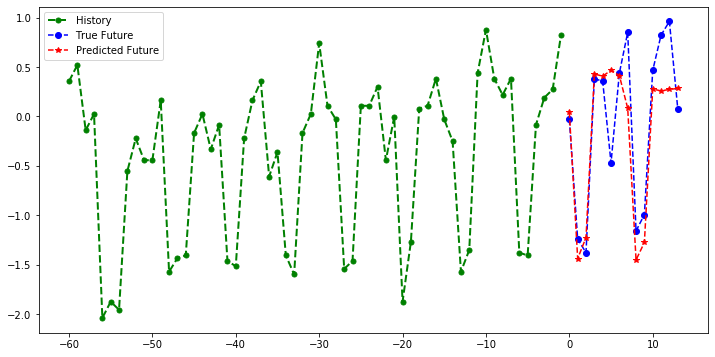

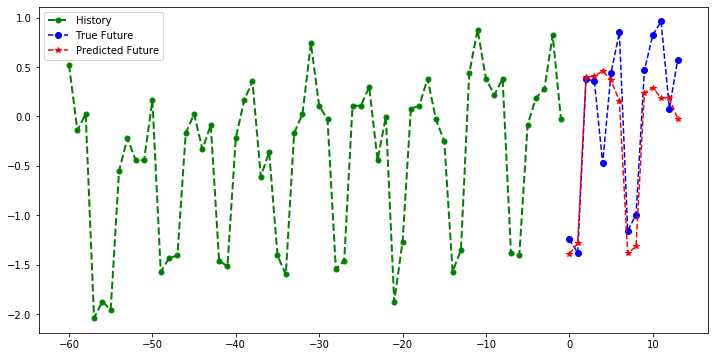

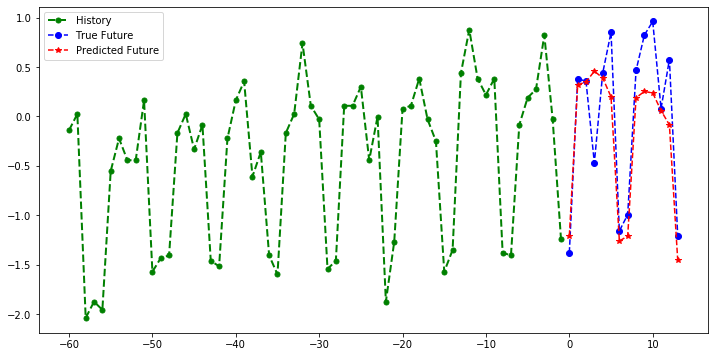

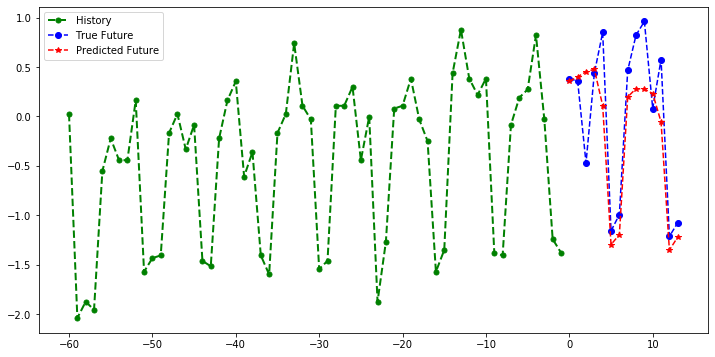

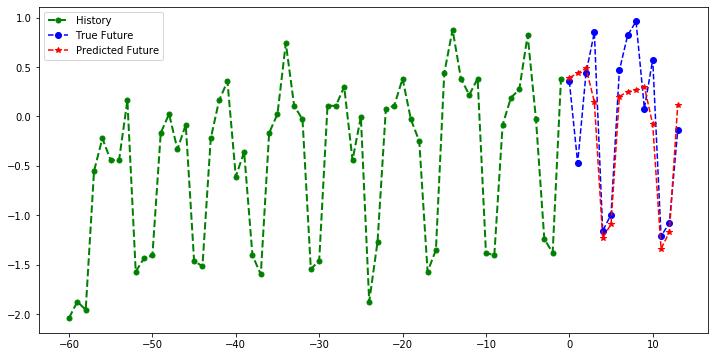

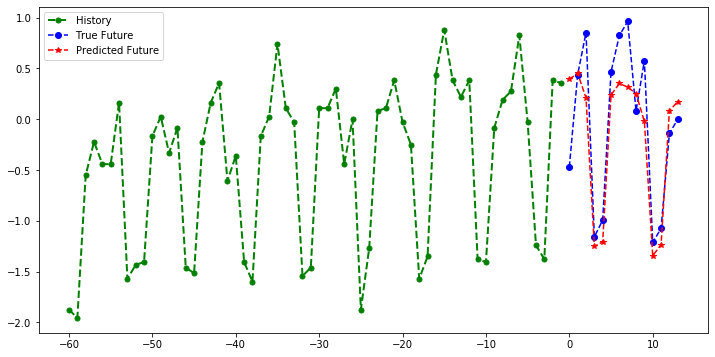

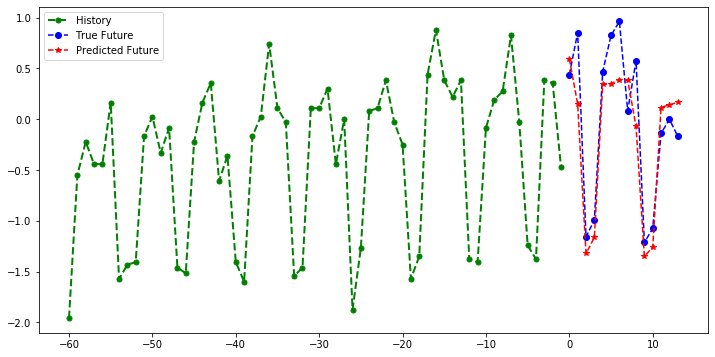

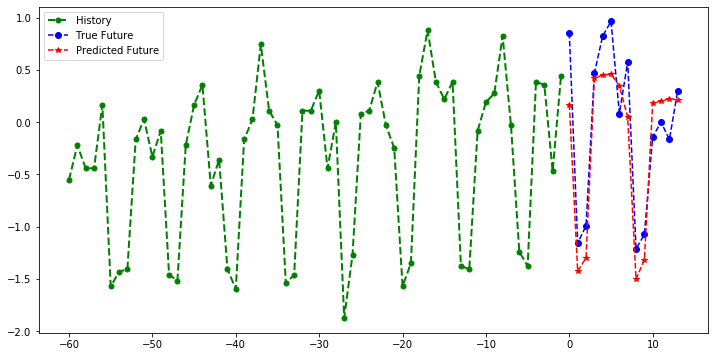

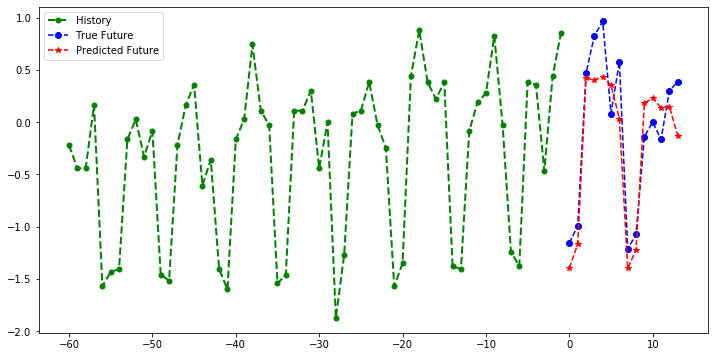

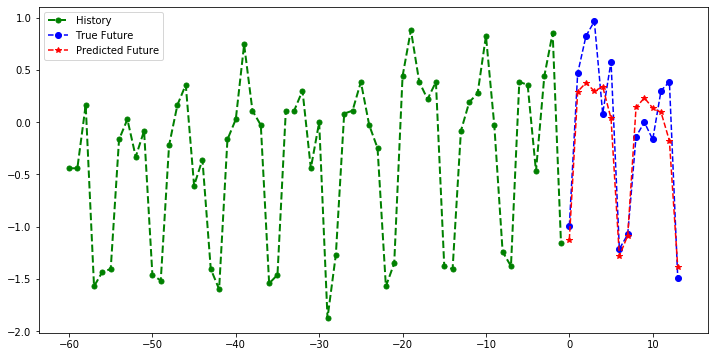

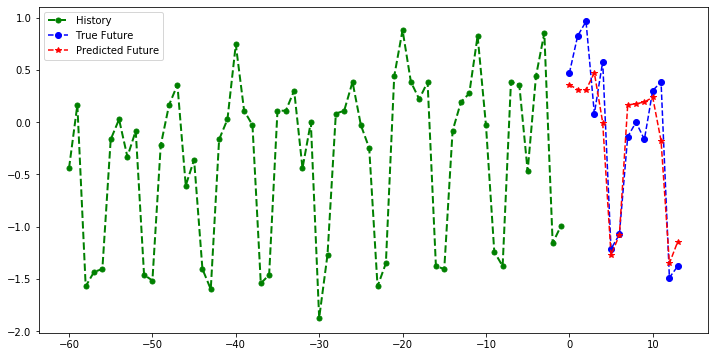

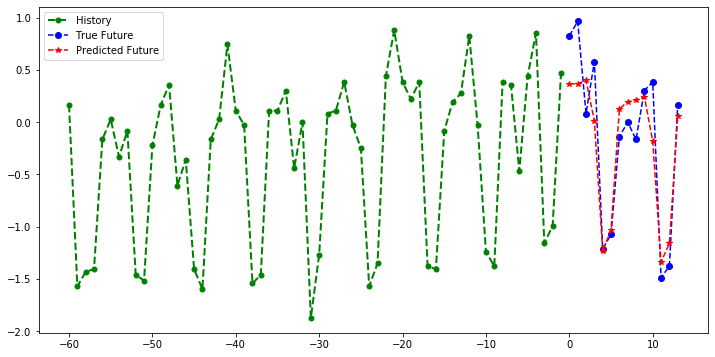

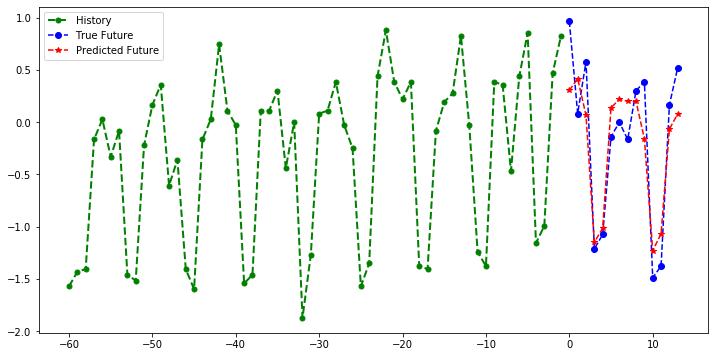

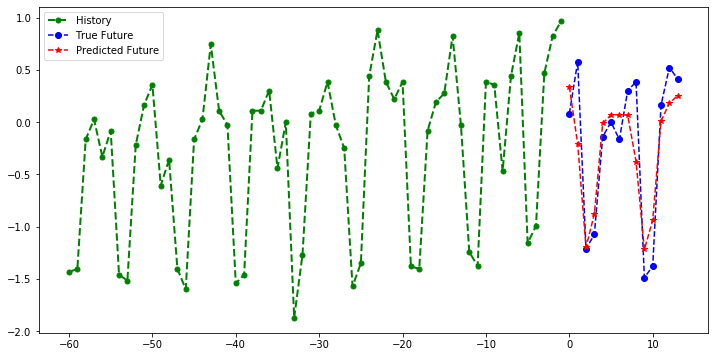

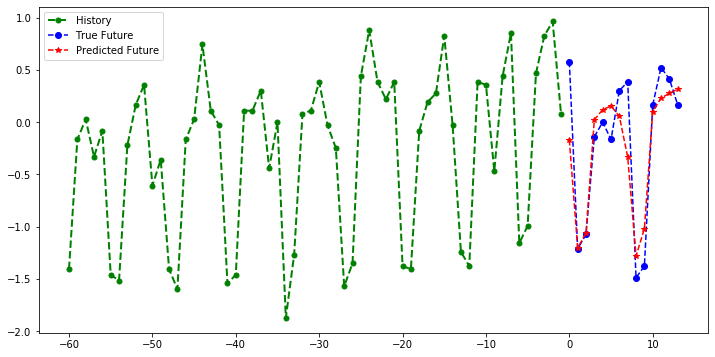

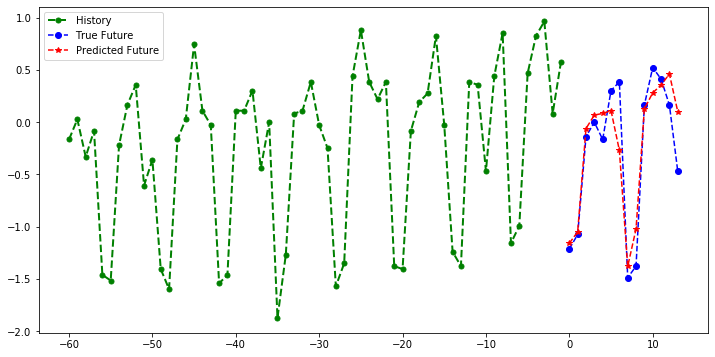

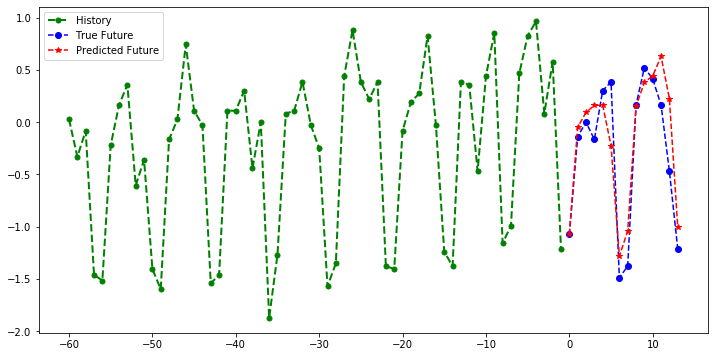

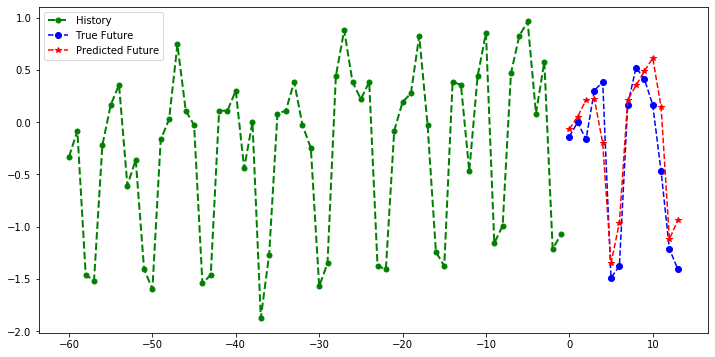

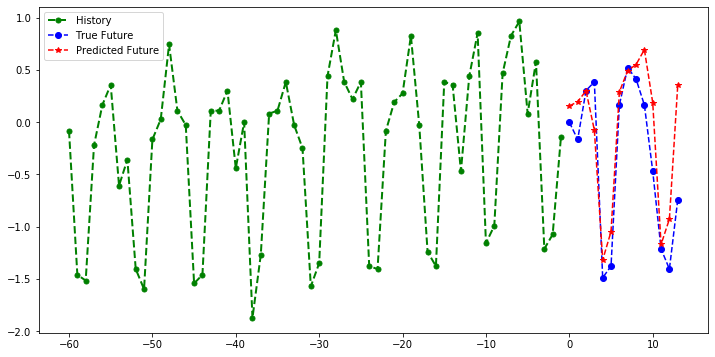

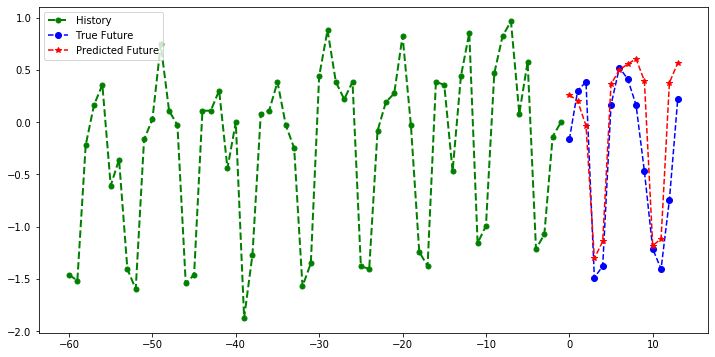

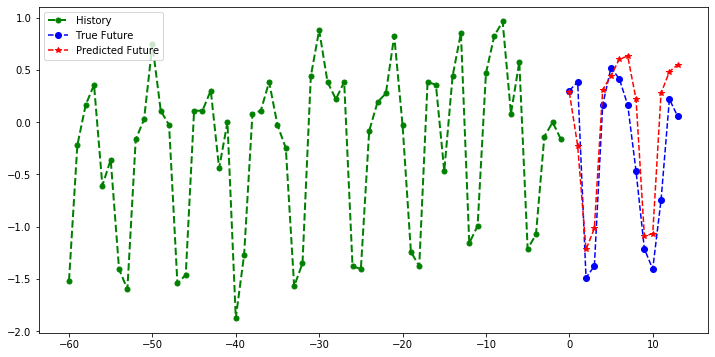

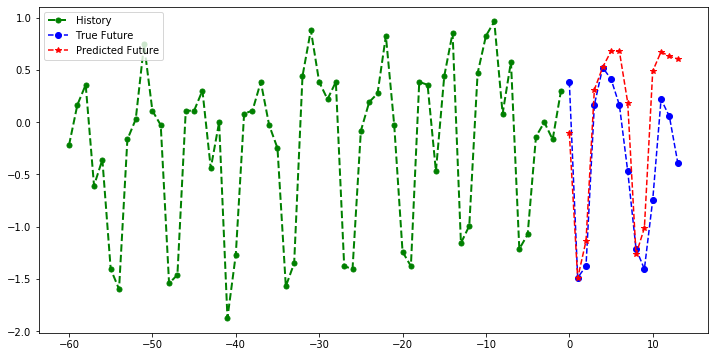

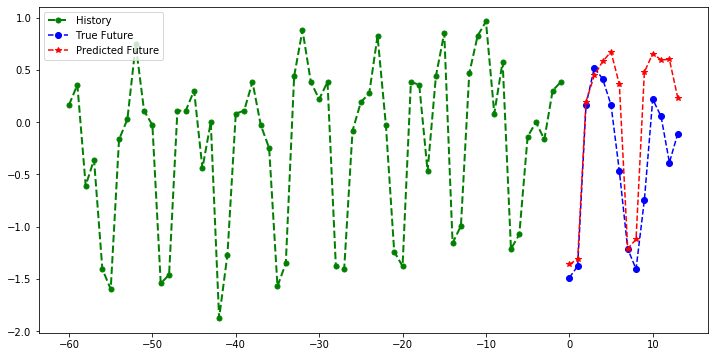

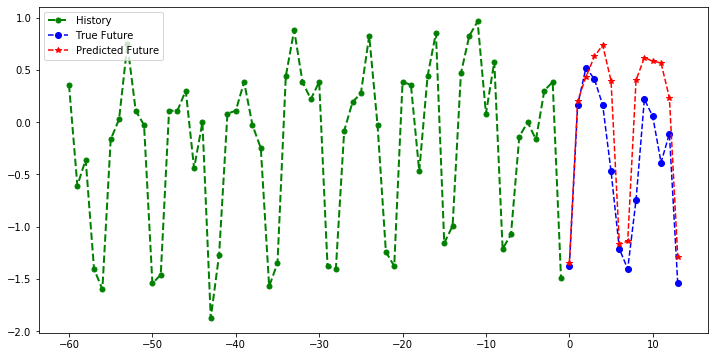

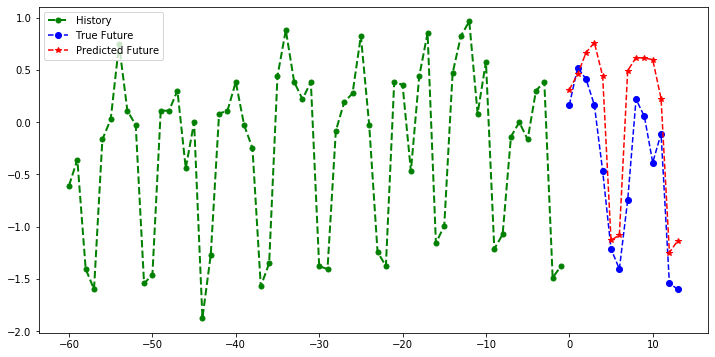

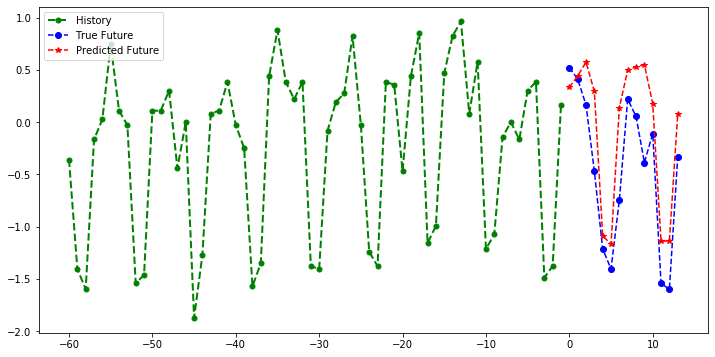

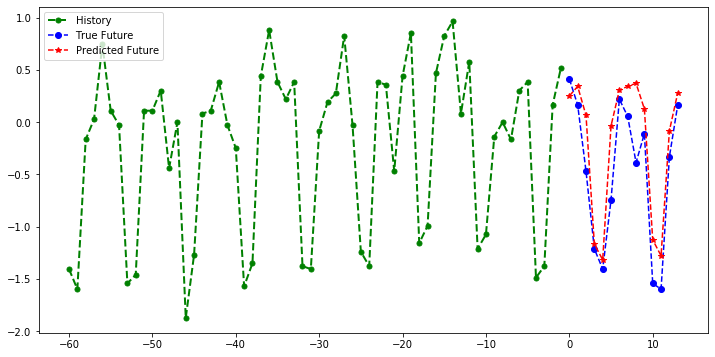

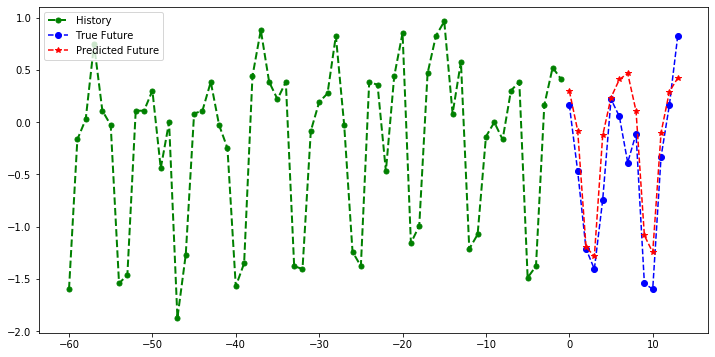

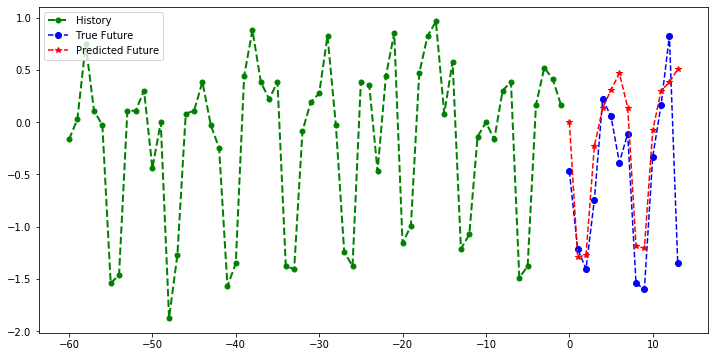

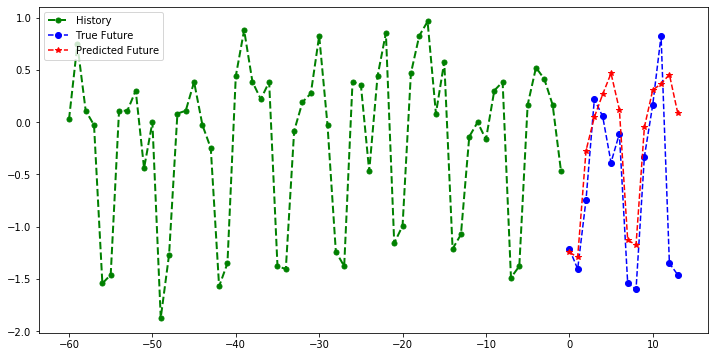

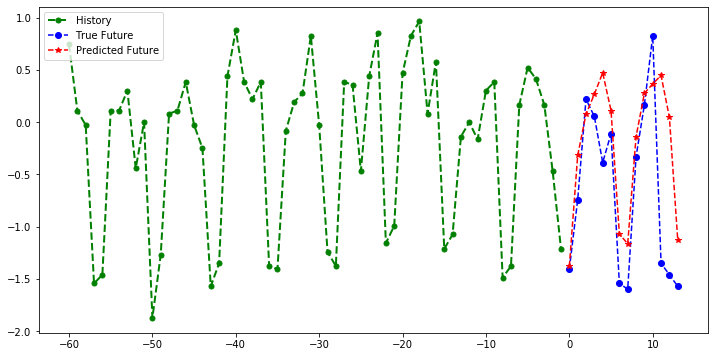

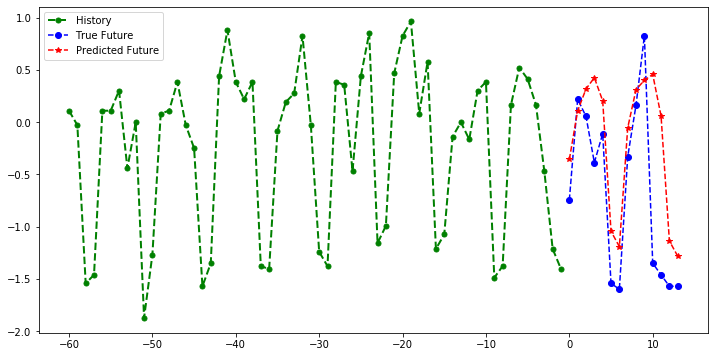

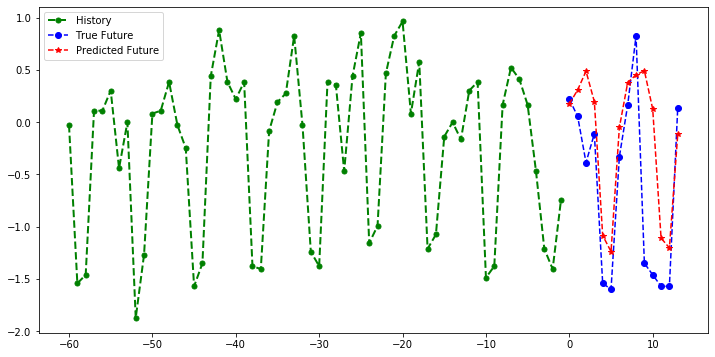

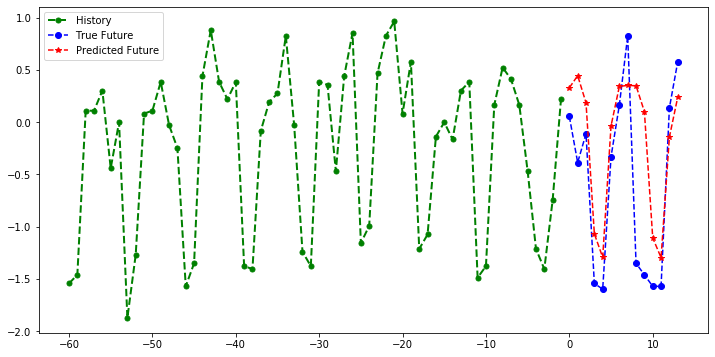

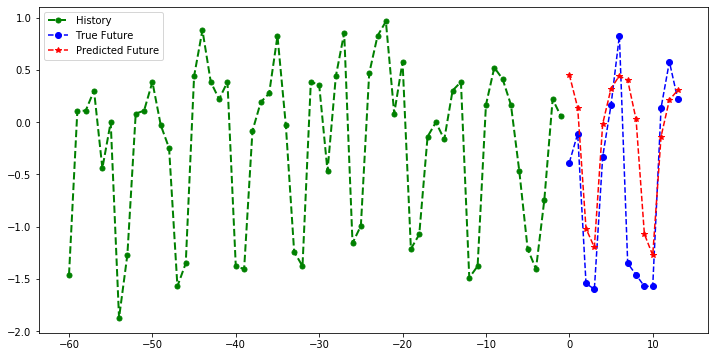

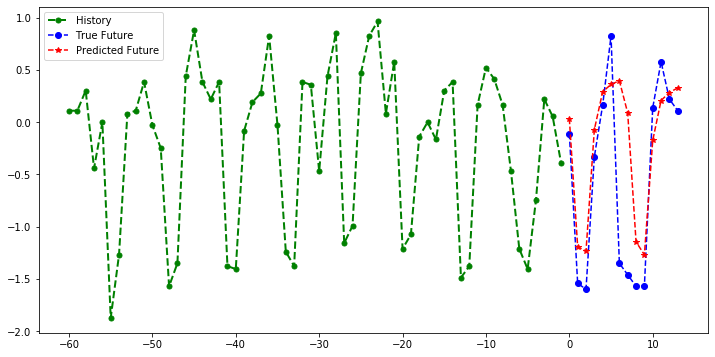

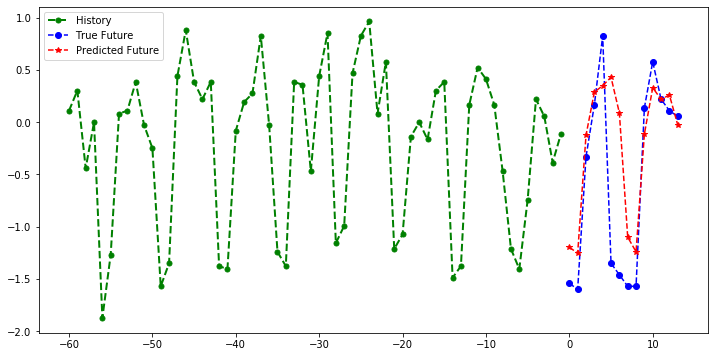

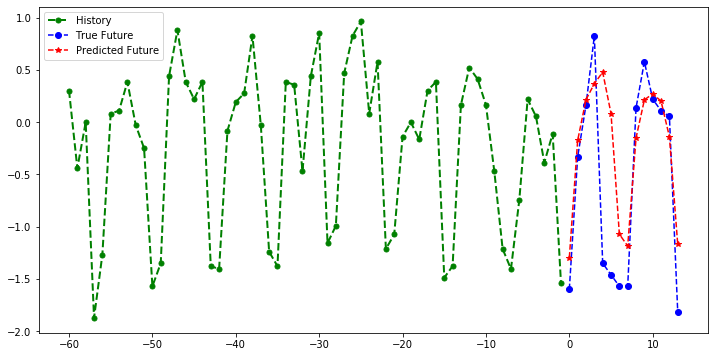

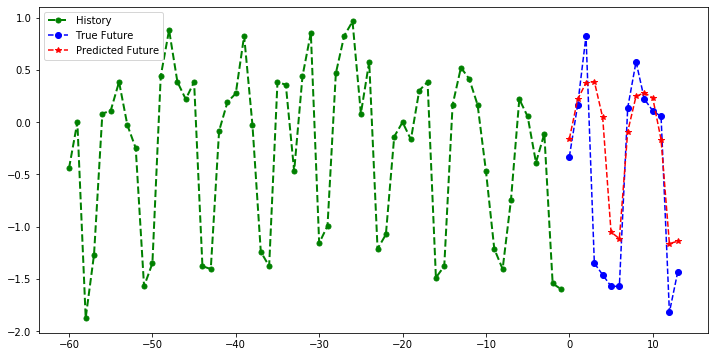

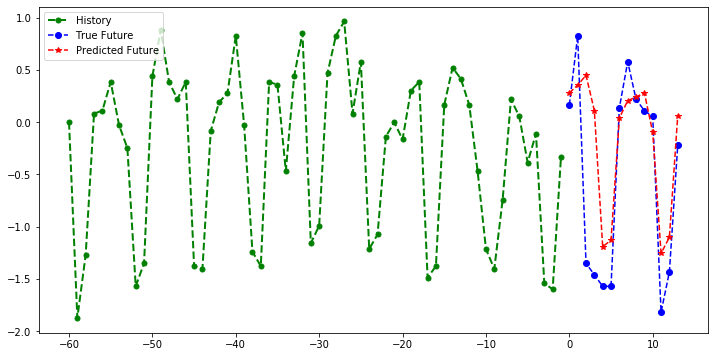

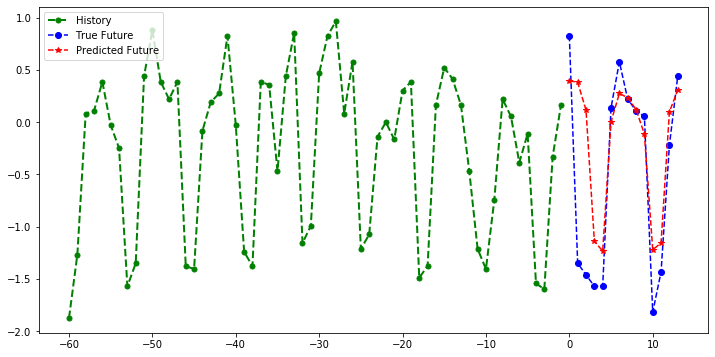

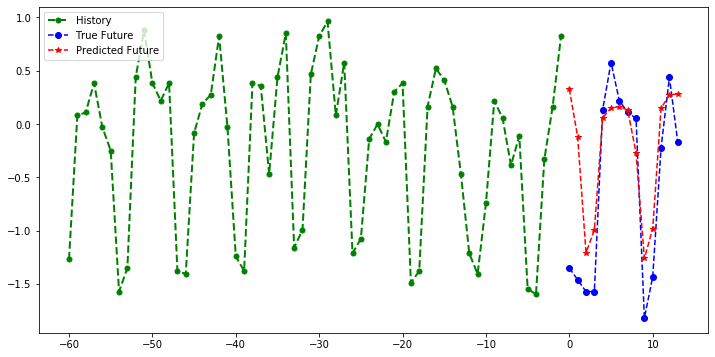

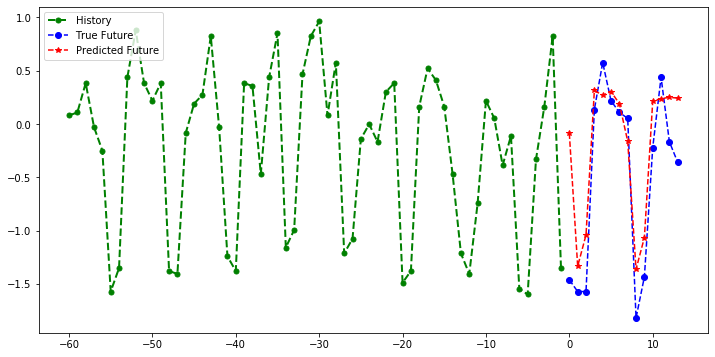

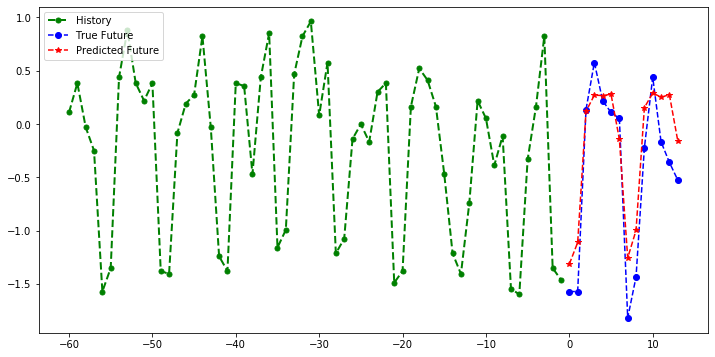

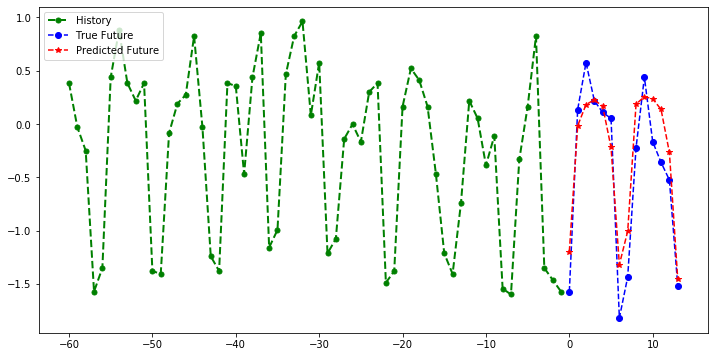

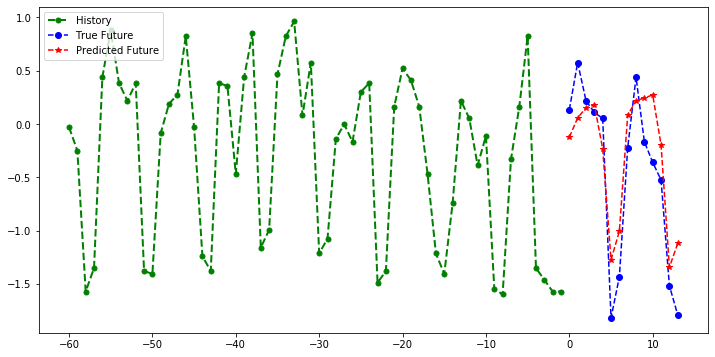

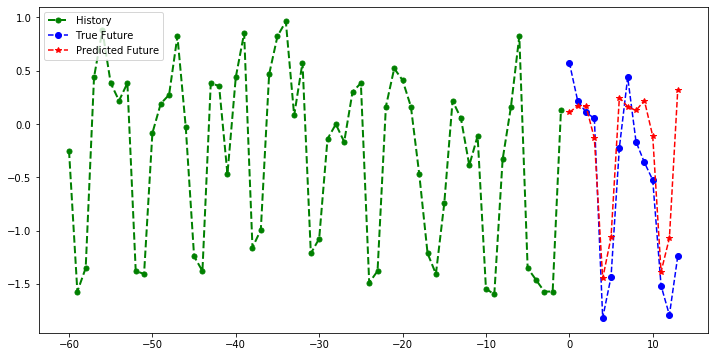

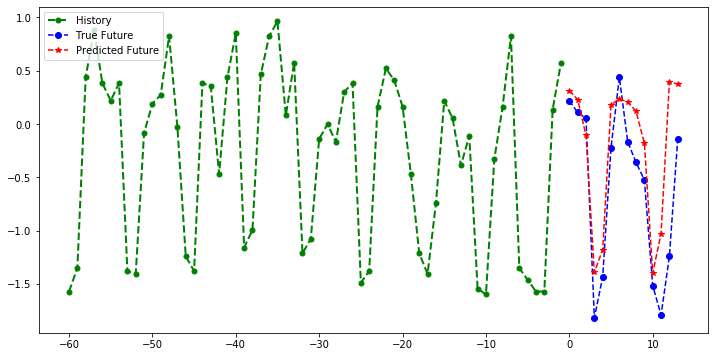

In [ ]:
# Plot the true value and predicted value
for x, y in val_univariate.take(1):
    for i in range(len(x)):
        multi_step_plot(x[i], y[i], multi_step_model.predict(x)[i])
